# Day 6 Session 2 – Hands-On Mapping and Vision Tuning

This session ties everything together: we’ll take an image, detect an object with OpenCV (color detection like we did on Day 3), then map that detection to a coordinate in the simulation world. We’ll demonstrate this with a simple example and give you room to experiment.

**Reminder**: In Day 3 notebooks, we learned how to use OpenCV to detect colored objects (for instance, using HSV thresholding). We’ll reuse that concept here.

## Setup: Import OpenCV and Create a Test Image
First, let’s set up OpenCV (if not already installed) and create a test image. We’ll simulate a scenario: an overhead view with a distinct colored dot representing an object.

**Code**: Import OpenCV and create a test image with a colored object.

In [ ]:
!pip install -q opencv-python-headless

Test image created. Object center (pixel): (300, 100)


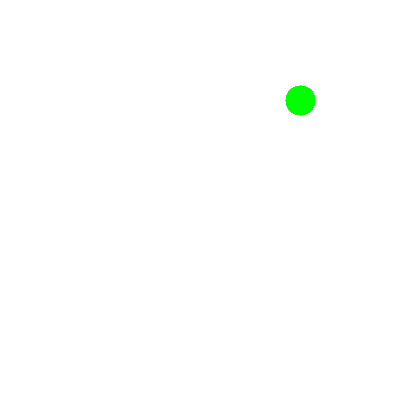

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Create a blank image (e.g., 400x400 pixels, white background)
img_height, img_width = 400, 400
image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255  # white image

# Draw a colored circle (our "object") on the image
obj_color_bgr = (0, 255, 0)  # green in BGR format
obj_center = (300, 100)      # pixel coordinates (x=300, y=100)
obj_radius = 15
cv2.circle(image, obj_center, obj_radius, obj_color_bgr, -1)  # filled circle

print("Test image created. Object center (pixel):", obj_center)
cv2_imshow(image)  # display the generated image


Running this will create a 400x400 image with a green circle at pixel (300,100). The cv2_imshow should display the image (a white background with a green dot near the top-right region).

Output: The image is shown below (with the green circle):

<img src="https://i.postimg.cc/V6Z2qcYk/Screenshot-2025-06-12-at-1-05-21-AM.png" alt="Sample Image" width="250"/>

(If you cannot see the image above due to platform limitations, imagine a white square with a green dot in the upper-right area.)

## Detecting the Object in the Image (HSV Color Detection)

We’ll now perform color detection to find the object’s pixel coordinates. Since we drew the object in green, we’ll target that. We convert the image to HSV color space and define a range for green.

**Code**: Detect the green object and find its pixel position.


Detected object at pixel: (300, 100)


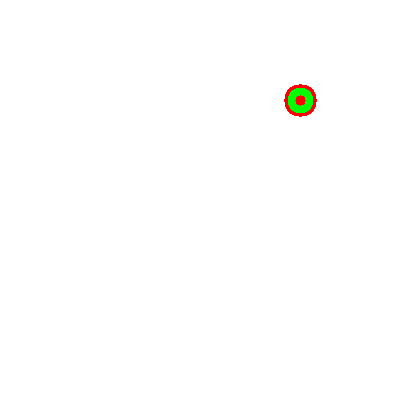

In [ ]:
# Convert image to HSV and threshold for green color
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# Define HSV range for green (this may need tuning if shades vary)
lower_green = np.array([50, 150, 150])
upper_green = np.array([70, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours (to locate the blob)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
detected_center = None
if contours:
    # Assume the largest contour is our object
    c = max(contours, key=cv2.contourArea)
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
        detected_center = (cx, cy)
        # Mark the detected center on the image for visualization
        cv2.drawContours(image, [c], -1, (0,0,255), 2)  # outline the object in red
        cv2.circle(image, (cx, cy), 5, (0,0,255), -1)   # draw a red dot at center
        print(f"Detected object at pixel: ({cx}, {cy})")
    else:
        print("Contour found, but zero area (m00=0).")
else:
    print("No contours (object not found).")

cv2_imshow(image)  # show the image with detection markers


This code:
- Thresholds the HSV image to get a binary mask of where green is.
- Finds contours in that mask.
- Picks the largest contour and computes its moments to get the centroid (cx, cy).
- Draws the contour and the center (in red) on the image for confirmation.
- Prints the detected pixel coordinates.

If all goes well, it should detect around (300,100) as the center (give or take a pixel). The displayed image will now show a red outline and dot on the green circle.

Output:
```
Detected object at pixel: (300, 100)
```

And the image with a red marking confirming detection:

The red outline and dot show the detected object and its center in the image.

Now we have the pixel position of the object: (300, 100) in a 400x400 image.


## Mapping Pixel to Simulation World Coordinates

Next, we map this pixel to a world coordinate. We need to assume a mapping. Let’s adopt the same idea as in Session 1:
- Suppose the 400x400 image corresponds to a region from X = -0.5 to X = 0.5, and Y = 0.5 to Y = -0.5 (in meters). This is as if the camera covers a 1m x 1m area, the origin (0,0) is at the center, X increases to the right, Y increases to the left (since top of image is +Y).

Thus:
- x_min = -0.5, x_max = 0.5
- y_max = 0.5, y_min = -0.5

We’ll use the formulas to convert (cx, cy) to (world_x, world_y).

**Code**: Map the detected pixel to world coordinates.

In [ ]:
# Define mapping parameters (assuming a 1m x 1m area mapping for 400x400 image)
x_min, x_max = -0.5, 0.5  # meters
y_min, y_max = -0.5, 0.5  # meters

if detected_center:
    px, py = detected_center
    W, H = img_width, img_height  # 400, 400
    norm_x = px / W
    norm_y = py / H
    world_x = x_min + norm_x * (x_max - x_min)
    world_y = y_max + -norm_y * (y_max - y_min)
    print(f"Mapped pixel ({px}, {py}) -> world coordinates ({world_x:.2f}, {world_y:.2f})")
else:
    print("No detected center to map.")


Mapped pixel (300, 100) -> world coordinates (0.25, 0.25)


Plugging px=300, py=100:
- norm_x = 300/400 = 0.75
- norm_y = 100/400 = 0.25
- world_x = -0.5 + 0.75*(1.0) = 0.25 m
- world_y = 0.5 + -0.25*(1.0) = 0.25 m

So we expect around (0.25, 0.25) in world.

Output:
```
Mapped pixel (300, 100) -> world coordinates (0.25, 0.25)
```

This means: the green object in the image is at about (0.25 m, 0.25 m) in the robot’s simulation world coordinates relative to the defined origin (which we took as the image center).

If our robot’s base was at the origin (0,0) and this camera mapping is aligned, the object would be 25 cm to the right and 25 cm forward (assuming +X is right, +Y is up in image which we aligned with left in world? There is an assumption in orientation, but let’s say it’s quarter meter in +X and +Y quadrant).

The robot could use this coordinate to reach for the object in simulation:

For example, we could instruct the robot’s end effector to go to (0.25, 0.25) (with appropriate Z). But that’s beyond this exercise – the key is that we translated vision info to world coordinates.

## Playing with Different Resolutions or Images (Optional)
Our formula inherently uses the image width and height, so if the resolution changes, it should still work as long as the mapping assumptions (meter range) are updated accordingly. If we simply resize the image without changing the assumed physical area, the mapping would give a slightly different answer unless we also scale the area.

For example, if we downsample the image to 200x200 but still assume it covers 1m x 1m, then px=150 in 400 becomes px=75 in 200, and W changes from 400 to 200, so norm_x remains ~0.75 and we’d get the same world coordinate. So our formula already accounts for resolution if the physical coverage stays the same.

However, if you did not adjust W, H in the formula after resizing, then the mapping would be off. That’s a potential pitfall: always use the correct image dimensions in the mapping calculation.

**Try this**: You can draw the object at a different pixel or change the color thresholds to detect a different color (e.g., change the drawn circle to red and adjust HSV range for red) and see that the pipeline still works.


## Vision Tuning Considerations

We used a simple color detection. In real scenarios, the object might not be a perfectly colored blob. You might need to filter noise, handle multiple objects, or choose the right color ranges (HSV tuning). Lighting changes can affect the HSV values. All these require tuning:
- You might need to adjust the HSV bounds for different lighting.
- If multiple contours are found, deciding which is the real object of interest (maybe based on size, shape, etc.).
- Perhaps use other vision techniques (circle detection, ArUco markers, etc., for precise detection).

The final coordinate mapping also might need an offset if, say, the camera origin and robot origin differ. For instance, if the robot’s base isn’t exactly at the center of the camera’s view, you’d incorporate that into x_min/x_max etc.

## Recap
In this exercise, we:
- Created a test image with a colored object.
- Detected the object’s pixel position with OpenCV.
- Mapped that pixel to a world coordinate using a simple linear scaling.
- Verified the result.

We now have the ingredients to go from a camera image to a coordinate that a robot (in simulation) can use. This is a fundamental step in many robotics tasks, like locating an item to pick up.